# Sample Solutions and Hints

__actuarialmath -- Life Contingent Risks with Python__

This package implements fundamental methods for modeling life contingent risks, and closely follows traditional topics covered in actuarial exams and standard texts such as the "Fundamentals of Actuarial Math - Long-term" exam syllabus by the Society of Actuaries, and "Actuarial Mathematics for Life Contingent Risks" by Dickson, Hardy and Waters.  These code chunks demonstrate how to solve each of the sample FAM-L exam questions released by the SOA.

Sources:

- SOA FAM-L Sample Solutions: [copy retrieved Aug 2022](https://terence-lim.github.io/notes/2022-10-exam-fam-l-sol.pdf)

- SOA FAM-L Sample Questions: [copy retrieved Aug 2022](https://terence-lim.github.io/notes/2022-10-exam-fam-l-quest.pdf)

- [Online tutorial](https://terence-lim.github.io/actuarialmath-tutorial/), or [download pdf](https://terence-lim.github.io/notes/actuarialmath-tutorial.pdf)

- [Code documentation](https://terence-lim.github.io/actuarialmath-docs)

- [Github repo](https://github.com/terence-lim/actuarialmath.git) and [issues](https://github.com/terence-lim/actuarialmath/issues)


In [ ]:
#! pip install actuarialmath

In [2]:
"""Solutions code and hints for SOA FAM-L sample questions

MIT License.  Copyright 2022-2023, Terence Lim
"""
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from actuarialmath.interest import Interest
from actuarialmath.life import Life
from actuarialmath.survival import Survival
from actuarialmath.lifetime import Lifetime
from actuarialmath.fractional import Fractional
from actuarialmath.insurance import Insurance
from actuarialmath.annuity import Annuity
from actuarialmath.premiums import Premiums
from actuarialmath.policyvalues import PolicyValues, Contract
from actuarialmath.reserves import Reserves
from actuarialmath.recursion import Recursion
from actuarialmath.lifetable import LifeTable
from actuarialmath.sult import SULT
from actuarialmath.selectlife import SelectLife
from actuarialmath.mortalitylaws import MortalityLaws, Beta, Uniform, Makeham, Gompertz
from actuarialmath.constantforce import ConstantForce
from actuarialmath.extrarisk import ExtraRisk
from actuarialmath.mthly import Mthly
from actuarialmath.udd import UDD
from actuarialmath.woolhouse import Woolhouse

__Helper to compare computed answers to expected solutions__

In [3]:
class IsClose:
    """Helper class for testing and reporting if two values are close"""
    def __init__(self, rel_tol : float = 0.01, score : bool = False,
                 verbose: bool = False):
        self.den = self.num = 0
        self.score = score      # whether to count INCORRECTs instead of assert
        self.verbose = verbose  # whether to run silently
        self.incorrect = []     # to keep list of messages for INCORRECT
        self.tol = rel_tol

    def __call__(self, solution, answer, question="", rel_tol=None):
        """Compare solution to answer within relative tolerance

        Args:
          solution (str | numeric) : gold label
          answer (str | numeric) : computed answer
          question (str) : label to associate with this test
          rel_tol (float) : relative tolerance to be considered close
        """
        if isinstance(solution, str):
            isclose = (solution == answer)
        else:
            isclose = math.isclose(solution, answer, rel_tol=rel_tol or self.tol)
        self.den += 1
        self.num += isclose
        msg = f"{question} {solution}: {answer}"
        if self.verbose:
            print("-----", msg, "[OK]" if isclose else "[INCORRECT]", "-----")
        if not self.score:
            assert isclose, msg
        if not isclose:
            self.incorrect.append(msg)
        return isclose

    def __str__(self):
        """Display cumulative score and errors"""
        return f"Passed: {self.num}/{self.den}\n" + "\n".join(self.incorrect)
isclose = IsClose(0.01, score=False, verbose=True)

## 1 Tables


These tables are provided in the FAM-L exam
- Interest Functions at i=0.05
- Normal Distribution Table
- Standard Ultimate Life Table

but you actually do not need them here!

In [4]:
print("Interest Functions at i=0.05")
UDD.interest_frame()

Interest Functions at i=0.05


,i(m),d(m),i/i(m),d/d(m),alpha(m),beta(m)
1,0.05000,0.04762,1.00000,1.00000,1.00000,0.00000
2,0.04939,0.04820,1.01235,0.98795,1.00015,0.25617
4,0.04909,0.04849,1.01856,0.98196,1.00019,0.38272
12,0.04889,0.04869,1.02271,0.97798,1.00020,0.46651
0,0.04879,0.04879,1.02480,0.97600,1.00020,0.50823


In [5]:
print("Values of z for selected values of Pr(Z<=z)")
print(Life.quantiles_frame().to_string(float_format=lambda x: f"{x:.3f}"))

Values of z for selected values of Pr(Z<=z)
z         0.842  1.036  1.282  1.645  1.960  2.326  2.576
Pr(Z<=z)  0.800  0.850  0.900  0.950  0.975  0.990  0.995


In [6]:
print("Standard Ultimate Life Table at i=0.05")
SULT().frame()

Standard Ultimate Life Table at i=0.05


,l_x,q_x,a_x,A_x,2A_x,a_x:10,A_x:10,a_x:20,A_x:20,5_E_x,10_E_x,20_E_x
20,100000.0,0.000250,19.9664,0.04922,0.00580,8.0991,0.61433,13.0559,0.37829,0.78252,0.61224,0.37440
21,99975.0,0.000253,19.9197,0.05144,0.00614,8.0990,0.61433,13.0551,0.37833,0.78250,0.61220,0.37429
22,99949.7,0.000257,19.8707,0.05378,0.00652,8.0988,0.61434,13.0541,0.37837,0.78248,0.61215,0.37417
23,99924.0,0.000262,19.8193,0.05622,0.00694,8.0986,0.61435,13.0531,0.37842,0.78245,0.61210,0.37404
24,99897.8,0.000267,19.7655,0.05879,0.00739,8.0983,0.61437,13.0519,0.37848,0.78243,0.61205,0.37390
...,...,...,...,...,...,...,...,...,...,...,...,...
96,17501.8,0.192887,3.5597,0.83049,0.69991,3.5356,0.83164,3.5597,0.83049,0.19872,0.01330,0.00000
97,14125.9,0.214030,3.3300,0.84143,0.71708,3.3159,0.84210,3.3300,0.84143,0.16765,0.00827,0.00000
98,11102.5,0.237134,3.1127,0.85177,0.73356,3.1050,0.85214,3.1127,0.85177,0.13850,0.00485,0.00000
99,8469.7,0.262294,2.9079,0.86153,0.74930,2.9039,0.86172,2.9079,0.86153,0.11173,0.00266,0.00000


## 2 Survival models

SOA Question 2.1: (B) 2.5
- derive formula for $\mu$ from given survival function
- solve for $\omega$ given $\mu_{65}$
- calculate $e$ by summing survival probabilities


In [7]:
life = Lifetime()
def mu_from_l(omega):   # first solve for omega, given mu_65 = 1/180            
    return life.set_survival(l=lambda x,s: (1 - (x+s)/omega)**0.25).mu_x(65)
omega = int(life.solve(mu_from_l, target=1/180, grid=100))
e = life.set_survival(l=lambda x,s:(1 - (x + s)/omega)**.25, maxage=omega)\
        .e_x(106)       # then solve expected lifetime from omega              
isclose(2.5, e, question="Q2.1")

----- Q2.1 2.5: 2.4786080555423604 [OK] -----


True

SOA Question 2.2: (D) 400
- calculate survival probabilities for the two scenarios
- apply conditional variance formula (or mixed distribution)

In [8]:
p1 = (1. - 0.02) * (1. - 0.01)  # 2_p_x if vaccine given
p2 = (1. - 0.02) * (1. - 0.02)  # 2_p_x if vaccine not given
std = math.sqrt(Life.conditional_variance(p=.2, p1=p1, p2=p2, N=100000))
isclose(400, std, question="Q2.2")

----- Q2.2 400: 396.5914603215815 [OK] -----


True

SOA Question 2.3: (A) 0.0483
1. Derive formula for $f$ given survival function

In [9]:
B, c = 0.00027, 1.1
S = lambda x,s,t: math.exp(-B * c**(x+s) * (c**t - 1)/math.log(c))
life = Survival().set_survival(S=S)
f = life.f_x(x=50, t=10)
isclose(0.0483, f, question="Q2.3")

----- Q2.3 0.0483: 0.048327399045049846 [OK] -----


True

SOA Question 2.4: (E) 8.2
- derive survival probability function $_tp_x$ given $_tq_0$
- compute $\overset{\circ}{e}$ by integration


In [10]:
def l(x, s): return 0. if (x+s) >= 100 else 1 - ((x + s)**2) / 10000.
e = Lifetime().set_survival(l=l).e_x(75, t=10, curtate=False)
isclose(8.2, e, question="Q2.4")

----- Q2.4 8.2: 8.20952380952381 [OK] -----


True

SOA Question 2.5:  (B) 37.1
- solve for $e_{40}$ from limited lifetime formula
- compute $e_{41}$ using backward recursion

In [11]:
life = Recursion(verbose=False).set_e(25, x=60, curtate=True)\
                               .set_q(0.2, x=40, t=20)\
                               .set_q(0.003, x=40)
def fun(e):   # solve e_40 from e_40:20 = e_40 - 20_p_40 e_60
    return life.set_e(e, x=40, curtate=True)\
               .e_x(x=40, t=20, curtate=True)
e40 = life.solve(fun, target=18, grid=[36, 41])
life.verbose=True
fun(e40)
e41 = life.e_x(41, curtate=True)
isclose(37.1, e41, question="Q2.5")

----- Q2.5 37.1: 37.11434302908726 [OK] -----


True

SOA Question 2.6: (C) 13.3
- derive force of mortality function $\mu$ from given survival function


In [12]:
life = Survival().set_survival(l=lambda x,s: (1 - (x+s)/60)**(1/3))
mu = 1000 * life.mu_x(35)
isclose(13.3, mu, question="Q2.6")

----- Q2.6 13.3: 13.340451278922776 [OK] -----


True

SOA Question 2.7: (B) 0.1477
- calculate from given survival function

In [13]:
l = lambda x,s: (1-((x+s)/250) if (x+s)<40 else 1-((x+s)/100)**2)
q = Survival().set_survival(l=l).q_x(30, t=20)
isclose(0.1477, q, question="Q2.7")

----- Q2.7 0.1477: 0.1477272727272727 [OK] -----


True

SOA Question 2.8: (C) 0.94
- relate $p_{male}$ and $p_{female}$ through the common term $\mu$ and the given proportions


In [14]:
def fun(mu):  # Solve first for mu, given ratio of start and end proportions
    male = Survival().set_survival(mu=lambda x,s: 1.5 * mu)
    female = Survival().set_survival(mu=lambda x,s: mu)
    return (75 * female.p_x(0, t=20)) / (25 * male.p_x(0, t=20))
mu = Survival.solve(fun, target=85/15, grid=[0.89, 0.99])
p = Survival().set_survival(mu=lambda x,s: mu).p_x(0, t=1)
isclose(0.94, p, question="Q2.8")

----- Q2.8 0.94: 0.9383813306903799 [OK] -----


True

## 3 Life tables and selection

SOA Question 3.1:  (B) 117
- interpolate with constant force of maturity


In [15]:
life = SelectLife().set_table(l={60: [80000, 79000, 77000, 74000],
                                 61: [78000, 76000, 73000, 70000],
                                 62: [75000, 72000, 69000, 67000],
                                 63: [71000, 68000, 66000, 65000]})
q = 1000 * life.q_r(60, s=0, r=0.75, t=3, u=2)
isclose(117, q, question="Q3.1")

----- Q3.1 117: 116.7192429022082 [OK] -----


True

SOA Question 3.2:  (D) 14.7
- UDD $\Rightarrow \overset{\circ}{e}_{x} = e_x + 0.5$
- fill select table using curtate expectations 


In [16]:
e_curtate = Fractional.e_approximate(e_complete=15)
life = SelectLife(udd=True).set_table(l={65: [1000, None,],
                                         66: [955, None]},
                                      e={65: [e_curtate, None]},
                                      d={65: [40, None,],
                                         66: [45, None]})
e = life.e_r(66)
isclose(14.7, e, question="Q3.2")

----- Q3.2 14.7: 14.67801047120419 [OK] -----


True

SOA Question 3.3:  (E) 1074
- interpolate lives between integer ages with UDD

In [17]:
life = SelectLife().set_table(l={50: [99, 96, 93],
                                 51: [97, 93, 89],
                                 52: [93, 88, 83],
                                 53: [90, 84, 78]})
q = 10000 * life.q_r(51, s=0, r=0.5, t=2.2)
isclose(1074, q, question="Q3.3")

----- Q3.3 1074: 1073.684210526316 [OK] -----


True

SOA Question 3.4:  (B) 815
- compute portfolio percentile with N=4000, and mean and variance  from binomial distribution

In [18]:
sult = SULT()
mean = sult.p_x(25, t=95-25)
var = sult.bernoulli(mean, variance=True)
pct = sult.portfolio_percentile(N=4000, mean=mean, variance=var, prob=0.1)
isclose(815, pct, question="Q3.4")

----- Q3.4 815: 815.0943255167722 [OK] -----


True

SOA Question 3.5:  (E) 106
- compute mortality rates by interpolating lives between integer ages, with UDD and constant force of mortality assumptions

In [19]:
l = [99999, 88888, 77777, 66666, 55555, 44444, 33333, 22222]
a = LifeTable(udd=True).set_table(l={age:l for age,l in zip(range(60, 68), l)})\
                       .q_r(60, u=3.4, t=2.5)
b = LifeTable(udd=False).set_table(l={age:l for age,l in zip(range(60, 68), l)})\
                        .q_r(60, u=3.4, t=2.5)
isclose(106, 100000 * (a - b), question="Q3.5")

----- Q3.5 106: 106.16575827938624 [OK] -----


True

SOA Question 3.6:  (D) 15.85
- apply recursion formulas for curtate expectation


In [20]:
e = SelectLife().set_table(q={60: [.09, .11, .13, .15],
                              61: [.1, .12, .14, .16],
                              62: [.11, .13, .15, .17],
                              63: [.12, .14, .16, .18],
                              64: [.13, .15, .17, .19]},
                           e={61: [None, None, None, 5.1]})\
                .e_x(61)
isclose(5.85, e, question="Q3.6")

----- Q3.6 5.85: 5.846832 [OK] -----


True

SOA Question 3.7: (b) 16.4
- use deferred mortality formula
- use chain rule for survival probabilities,
- interpolate between integer ages with constant force of mortality


In [21]:
life = SelectLife().set_table(q={50: [.0050, .0063, .0080],
                                 51: [.0060, .0073, .0090],
                                 52: [.0070, .0083, .0100],
                                 53: [.0080, .0093, .0110]})
q = 1000 * life.q_r(50, s=0, r=0.4, t=2.5)
isclose(16.4, q, question="Q3.7")

----- Q3.7 16.4: 16.420207214428586 [OK] -----


True

SOA Question 3.8:  (B) 1505
- compute portfolio means and variances from sum of 2000 independent members' means and variances of survival.


In [22]:
sult = SULT()
p1 = sult.p_x(35, t=40)
p2 = sult.p_x(45, t=40)
mean = sult.bernoulli(p1) * 1000 + sult.bernoulli(p2) * 1000
var = (sult.bernoulli(p1, variance=True) * 1000 
       + sult.bernoulli(p2, variance=True) * 1000)
pct = sult.portfolio_percentile(mean=mean, variance=var, prob=.95)
isclose(1505, pct, question="Q3.8")

----- Q3.8 1505: 1504.8328375406456 [OK] -----


True

SOA Question 3.9:  (E) 3850
- compute portfolio means and variances as sum of 4000 independent members' means and variances (of survival)
- retrieve normal percentile


In [23]:
sult = SULT()
p1 = sult.p_x(20, t=25)
p2 = sult.p_x(45, t=25)
mean = sult.bernoulli(p1) * 2000 + sult.bernoulli(p2) * 2000
var = (sult.bernoulli(p1, variance=True) * 2000 
       + sult.bernoulli(p2, variance=True) * 2000)
pct = sult.portfolio_percentile(mean=mean, variance=var, prob=.99)
isclose(3850, pct, question="Q3.9")

----- Q3.9 3850: 3850.144345130047 [OK] -----


True

SOA Question 3.10:  (C) 0.86
- reformulate the problem by reversing time: survival to year 6 is calculated in reverse as discounting by the same number of years. 



In [24]:
interest = Interest(v=0.75)
L = 35*interest.annuity(t=4, due=False) + 75*interest.v_t(t=5)
interest = Interest(v=0.5)
R = 15*interest.annuity(t=4, due=False) + 25*interest.v_t(t=5)
isclose(0.86, L / (L + R), question="Q3.10")

----- Q3.10 0.86: 0.8578442833761983 [OK] -----


True

SOA Question 3.11:  (B) 0.03
- calculate mortality rate by interpolating lives assuming UDD


In [25]:
life = LifeTable(udd=True).set_table(q={50//2: .02, 52//2: .04})
q = life.q_r(50//2, t=2.5/2)
isclose(0.03, q, question="Q3.11")

----- Q3.11 0.03: 0.0298 [OK] -----


True

SOA Question 3.12: (C) 0.055 
- compute survival probability by interpolating lives assuming constant force


In [26]:
life = SelectLife(udd=False).set_table(l={60: [10000, 9600, 8640, 7771],
                                          61: [8654, 8135, 6996, 5737],
                                          62: [7119, 6549, 5501, 4016],
                                          63: [5760, 4954, 3765, 2410]})
q = life.q_r(60, s=1, t=3.5) - life.q_r(61, s=0, t=3.5)               
isclose(0.055, q, question="Q3.12")

----- Q3.12 0.055: 0.05465655938591829 [OK] -----


True

SOA Question 3.13:  (B) 1.6
- compute curtate expectations using recursion formulas
- convert to complete expectation assuming UDD


In [27]:
life = SelectLife().set_table(l={55: [10000, 9493, 8533, 7664],
                                 56: [8547, 8028, 6889, 5630],
                                 57: [7011, 6443, 5395, 3904],
                                 58: [5853, 4846, 3548, 2210]},
                              e={57: [None, None, None, 1]})
e = life.e_r(58, s=2)
isclose(1.6, e, question="Q3.13")

----- Q3.13 1.6: 1.6003382187147688 [OK] -----


True

SOA Question 3.14:  (C) 0.345
- compute mortality by interpolating lives between integer ages assuming UDD


In [28]:
life = LifeTable(udd=True).set_table(l={90: 1000, 93: 825},
                                     d={97: 72},
                                     p={96: .2},
                                     q={95: .4, 97: 1})
q = life.q_r(90, u=93-90, t=95.5 - 93)
isclose(0.345, q, question="Q3.14")

----- Q3.14 0.345: 0.345 [OK] -----


True

## 4 Insurance benefits

SOA Question 4.1:  (A) 0.27212
- solve EPV as sum of term and deferred insurance
- compute variance as difference of second moment and first moment squared


In [29]:
life = Recursion().set_interest(i=0.03)
life.set_A(0.36987, x=40).set_A(0.62567, x=60)
life.set_E(0.51276, x=40, t=20).set_E(0.17878, x=60, t=20)
Z2 = 0.24954
A = (2 * life.term_insurance(40, t=20) + life.deferred_insurance(40, u=20))
std = math.sqrt(life.insurance_variance(A2=Z2, A1=A))
isclose(0.27212, std, question="Q4.1")

----- Q4.1 0.27212: 0.2721117749374753 [OK] -----


True

SOA Question 4.2:  (D) 0.18
- calculate Z(t) and deferred mortality for each half-yearly t
- sum the deferred mortality probabilities for periods when PV > 277000 


In [30]:
life = LifeTable(udd=False).set_table(q={0: .16, 1: .23})\
                           .set_interest(i_m=.18, m=2)
mthly = Mthly(m=2, life=life)
Z = mthly.Z_m(0, t=2, benefit=lambda x,t: 300000 + t*30000*2)
p = Z[Z['Z'] >= 277000]['q'].sum()
isclose(0.18, p, question="Q4.2")

----- Q4.2 0.18: 0.17941813045022975 [OK] -----


True

SOA Question 4.3: (D) 0.878
- solve $q_{61}$ from endowment insurance EPV formula
- solve $A_{60:\overline{3|}}$ with new $i=0.045$ as EPV of endowment insurance benefits.


In [31]:
life = Recursion(verbose=False).set_interest(i=0.05).set_q(0.01, x=60)
def fun(q):   # solve for q_61
    return life.set_q(q, x=61).endowment_insurance(60, t=3)
life.solve(fun, target=0.86545, grid=0.01)
A = life.set_interest(i=0.045).endowment_insurance(60, t=3)
isclose(0.878, A, question="Q4.3")

----- Q4.3 0.878: 0.8777667236003878 [OK] -----


True

SOA Question 4.4  (A) 0.036
- integrate to find EPV of $Z$ and $Z^2$
- variance is difference of second moment and first moment squared


In [32]:
x = 40
life = Insurance().set_survival(f=lambda *x: 0.025, maxage=x+40)\
                  .set_interest(v_t=lambda t: (1 + .2*t)**(-2))
def benefit(x,t): return 1 + .2 * t
A1 = life.A_x(x, benefit=benefit, discrete=False)
A2 = life.A_x(x, moment=2, benefit=benefit, discrete=False)
var = A2 - A1**2
isclose(0.036, var, question="Q4.4")

----- Q4.4 0.036: 0.03567680106032681 [OK] -----


True

SOA Question 4.5:  (C) 35200
- interpolate between integer ages with UDD, and find lifetime that mortality rate exceeded
- compute PV of death benefit paid at that time.


In [33]:
sult = SULT(udd=True).set_interest(delta=0.05)
Z = 100000 * sult.Z_from_prob(45, 0.95, discrete=False)
isclose(35200, Z, question="Q4.5")

----- Q4.5 35200: 35187.952037196534 [OK] -----


True

SOA Question 4.6:  (B) 29.85
- calculate adjusted mortality rates
- compute term insurance as EPV of benefits

In [34]:
sult = SULT()
life = LifeTable().set_interest(i=0.05)\
                  .set_table(q={70+k: .95**k * sult.q_x(70+k) for k in range(3)})
A = life.term_insurance(70, t=3, b=1000)
isclose(29.85, A, question="Q4.6")

----- Q4.6 29.85: 29.84835110355902 [OK] -----


True

SOA Question 4.7:  (B) 0.06
- use Bernoulli shortcut formula for variance of pure endowment Z 
- solve for $i$, since $p$ is given.

In [35]:
def fun(i):
    life = Recursion(verbose=False).set_interest(i=i)\
                                   .set_p(0.57, x=0, t=25)
    return 0.1*life.E_x(0, t=25) - life.E_x(0, t=25, moment=life._VARIANCE)
i = Recursion.solve(fun, target=0, grid=[0.058, 0.066])
isclose(0.06, i, question="Q4.7")

----- Q4.7 0.06: 0.06008023738770262 [OK] -----


True

SOA Question 4.8  (C) 191

- use insurance recursion with special interest rate $i=0.04$ in first year.


In [36]:
def v_t(t): return 1.04**(-t) if t < 1 else 1.04**(-1) * 1.05**(-t+1)
A = SULT().set_interest(v_t=v_t).whole_life_insurance(50, b=1000)
isclose(191, A, question="Q4.8")

----- Q4.8 191: 191.1281281882354 [OK] -----


True

SOA Question 4.9:  (D) 0.5
- use whole-life, term and endowment insurance relationships.


In [37]:
E = Recursion().set_A(0.39, x=35, t=15, endowment=1)\
               .set_A(0.25, x=35, t=15)\
               .E_x(35, t=15)
life = Recursion().set_A(0.32, x=35)\
                  .set_E(E, x=35, t=15)
def fun(A): return life.set_A(A, x=50).term_insurance(35, t=15)
A = life.solve(fun, target=0.25, grid=[0.35, 0.55])
isclose(0.5, A, question="Q4.9")

 *Pure Endowment E_35(t=15) <--
   E_35(t=15) = A_35(t=15,endow=1) - A_35(t=15)     ~endowment insurance minus term
----- Q4.9 0.5: 0.5 [OK] -----


True

SOA Question 4.10:  (D)
- draw and compared benefit diagrams


----- Q4.10 D: D [OK] -----


True

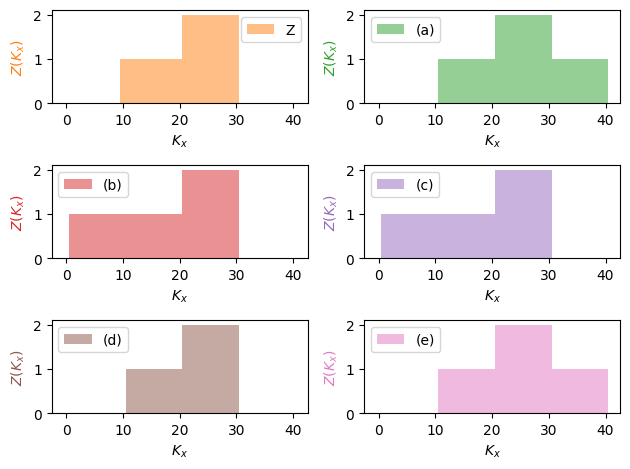

In [38]:
life = Insurance().set_interest(i=0.0).set_survival(S=lambda x,s,t: 1, maxage=40)
def fun(x, t):
    if 10 <= t <= 20: return life.interest.v_t(t)
    elif 20 < t <= 30: return 2 * life.interest.v_t(t)
    else: return 0
def A(x, t):  # Z_x+k (t-k)
    return life.interest.v_t(t - x) * (t > x)
x = 0
benefits=[lambda x,t: (life.E_x(x, t=10) * A(x+10, t)
                            + life.E_x(x, t=20)* A(x+20, t) 
                            - life.E_x(x, t=30) * A(x+30, t)),
          lambda x,t: (A(x, t)  
                       + life.E_x(x, t=20) * A(x+20, t) 
                       - 2 * life.E_x(x, t=30) * A(x+30, t)),
          lambda x,t: (life.E_x(x, t=10) * A(x, t) 
                       + life.E_x(x, t=20) * A(x+20, t) 
                       - 2 * life.E_x(x, t=30) * A(x+30, t)),
          lambda x,t: (life.E_x(x, t=10) * A(x+10, t) 
                       + life.E_x(x, t=20) * A(x+20, t) 
                       - 2 * life.E_x(x, t=30) * A(x+30, t)),
          lambda x,t: (life.E_x(x, t=10)
                       * (A(x+10, t) 
                          + life.E_x(x+10, t=10) * A(x+20, t) 
                          - life.E_x(x+20, t=10) * A(x+30, t)))]
fig, ax = plt.subplots(3, 2)
ax = ax.ravel()
for i, b in enumerate([fun] + benefits):
    life.Z_plot(0, benefit=b, ax=ax[i], color=f"C{i+1}", title='')
    ax[i].legend(["(" + "abcde"[i-1] + ")" if i else "Z"])
z = [sum(abs(b(0, t) - fun(0, t)) for t in range(40)) for b in benefits]
ans = "ABCDE"[np.argmin(z)]
isclose('D', ans, question="Q4.10")

SOA Question 4.11:  (A) 143385
- compute endowment insurance = term insurance + pure endowment 
- apply formula of variance as the difference of second moment and first moment squared.


In [39]:
A1 = 528/1000   # E[Z1]  term insurance
C1 = 0.209      # E[pure_endowment]
C2 = 0.136      # E[pure_endowment^2]
B1 = A1 + C1    # endowment = term + pure_endowment
def fun(A2):
    B2 = A2 + C2   # double force of interest
    return Insurance.insurance_variance(A2=B2, A1=B1)  
A2 = Insurance.solve(fun, target=15000/(1000*1000), grid=[143400, 279300])
var = Insurance.insurance_variance(A2=A2, A1=A1, b=1000)
isclose(143385, var, question="Q4.11")

----- Q4.11 143385: 143384.99999999997 [OK] -----


True

SOA Question 4.12:  (C) 167 
- since $Z_1,~Z_2$ are non-overlapping, $E[Z_1~ Z_2] = 0$ for computing $Cov(Z_1, Z_2)$
- whole life is sum of term and deferred, hence equals variance of components plus twice their covariance


In [40]:
cov = Life.covariance(a=1.65, b=10.75, ab=0)  # E[Z1 Z2] = 0 nonoverlapping
var = Life.variance(a=2, b=1, var_a=46.75, var_b=50.78, cov_ab=cov)
isclose(167, var, question="Q4.12")

----- Q4.12 167: 166.82999999999998 [OK] -----


True

SOA Question 4.13:  (C) 350 
- compute term insurance as EPV of benefits

In [41]:
life = SelectLife().set_table(q={65: [.08, .10, .12, .14],
                                 66: [.09, .11, .13, .15],
                                 67: [.10, .12, .14, .16],
                                 68: [.11, .13, .15, .17],
                                 69: [.12, .14, .16, .18]})\
                   .set_interest(i=.04)
A = life.deferred_insurance(65, t=2, u=2, b=2000)
isclose(350, A, question="Q4.13")

----- Q4.13 350: 351.0578236056159 [OK] -----


True

SOA Question 4.14:  (E) 390000
- discount (by interest rate $i=0.05$) the value at the portfolio percentile, of the sum of 400 bernoulli r.v. with survival probability $_{25}p_{60}$


In [42]:
sult = SULT()
p = sult.p_x(60, t=85-60)
mean = sult.bernoulli(p)
var = sult.bernoulli(p, variance=True)
F = sult.portfolio_percentile(mean=mean, variance=var, prob=.86, N=400)
F *= 5000 * sult.interest.v_t(85-60)
isclose(390000, F, question="Q4.14")

----- Q4.14 390000: 389322.86778416135 [OK] -----


True

SOA Question 4.15  (E) 0.0833 
- this special benefit function has effect of reducing actuarial discount rate to use in constant force of mortality shortcut formulas


In [43]:
life = Insurance().set_survival(mu=lambda *x: 0.04).set_interest(delta=0.06)
benefit = lambda x,t: math.exp(0.02*t)
A1 = life.A_x(0, benefit=benefit, discrete=False)
A2 = life.A_x(0, moment=2, benefit=benefit, discrete=False)
var = life.insurance_variance(A2=A2, A1=A1)
isclose(0.0833, var, question="Q4.15")

----- Q4.15 0.0833: 0.08334849338238598 [OK] -----


True

SOA Question 4.16:  (D) 0.11
- compute EPV of future benefits with adjusted mortality rates

In [44]:
q = [.045, .050, .055, .060]
q = {50 + x: [q[x] * 0.7 if x < len(q) else None, 
              q[x+1] * 0.8 if x + 1 < len(q) else None, 
              q[x+2] if x + 2 < len(q) else None] 
     for x in range(4)}
life = SelectLife().set_table(q=q).set_interest(i=.04)
A = life.term_insurance(50, t=3)
isclose(0.1116, A, question="Q4.16")

----- Q4.16 0.1116: 0.1115661982248521 [OK] -----


True

SOA Question 4.17:  (A) 1126.7
- find future lifetime with 50\% survival probability
- compute EPV of special whole life as sum of term and deferred insurance, that have different benefit amounts before and after median lifetime.

In [45]:
sult = SULT()
median = sult.Z_t(48, prob=0.5, discrete=False)
def benefit(x,t): return 5000 if t < median else 10000
A = sult.A_x(48, benefit=benefit)
isclose(1130, A, question="Q4.17")

----- Q4.17 1130: 1126.774772894844 [OK] -----


True

SOA Question 4.18  (A) 81873 
- find values of limits such that integral of lifetime density function equals required survival probability


In [46]:
def f(x,s,t): return 0.1 if t < 2 else 0.4*t**(-2)
life = Insurance().set_interest(delta=0.05)\
                  .set_survival(f=f, maxage=10)
def benefit(x,t): return 0 if t < 2 else 100000
prob = 0.9 - life.q_x(0, t=2)
T = life.Z_t(0, prob=prob)
Z = life.Z_from_t(T) * benefit(0, T)
isclose(81873, Z, question="Q4.18")

----- Q4.18 81873: 81873.07530779815 [OK] -----


True

SOA Question 4.19:  (B) 59050
- calculate adjusted mortality for the one-year select period
- compute whole life insurance using backward recursion formula


In [47]:
life = SULT()
q = ExtraRisk(life=life, extra=0.8, risk="MULTIPLY_RATE")['q']
select = SelectLife(periods=1).set_select(s=0, age_selected=True, q=q)\
                              .set_select(s=1, age_selected=False, q=life['q'])\
                              .set_interest(i=.05)\
                              .fill_table()
A = 100000 * select.whole_life_insurance(80, s=0)
isclose(59050, A, question="Q4.19")

----- Q4.19 59050: 59050.59973285648 [OK] -----


True

## 5 Annuities

SOA Question 5.1: (A) 0.705
- sum of annuity certain and deferred life annuity with constant force of mortality shortcut
- use equation for PV annuity r.v. Y to infer lifetime
- compute survival probability from constant force of mortality function.


In [48]:
life = ConstantForce(mu=0.01).set_interest(delta=0.06)
EY = life.certain_life_annuity(0, u=10, discrete=False)
p = life.p_x(0, t=life.Y_to_t(EY))
isclose(0.705, p, question="Q5.1")  # 0.705

----- Q5.1 0.705: 0.7053680433746505 [OK] -----


True

SOA Question 5.2:  (B) 9.64
- compute term life as difference of whole life and deferred insurance
- compute twin annuity-due, and adjust to an immediate annuity. 

In [49]:
x, n = 0, 10
a = Recursion().set_interest(i=0.05)\
               .set_A(0.3, x)\
               .set_A(0.4, x+n)\
               .set_E(0.35, x, t=n)\
               .immediate_annuity(x, t=n)
isclose(9.64, a, question="Q5.2")

 *Whole Life Annuity a_0(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
      a_0(t=1) = 1                                  ~one-year discrete annuity
      a_1(t=1) = 1                                  ~one-year discrete annuity
 *Whole Life Annuity a_10(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
      a_10(t=1) = 1                                 ~one-year discrete annuity
      a_11(t=1) = 1                                 ~one-year discrete annuity
----- Q5.2 9.64: 9.639999999999999 [OK] -----


True

SOA Question 5.3:  (C) 6.239
- Differential reduces to the the EPV of the benefit payment at the upper time limit.


In [50]:
t = 10.5
E = t * SULT().E_r(40, t=t)
isclose(6.239, E, question="Q5.3")

----- Q5.3 6.239: 6.23871918627528 [OK] -----


True

SOA Question 5.4:  (A) 213.7
- compute certain and life annuity factor as the sum of a certain annuity and a deferred life annuity.
- solve for amount of annual benefit that equals given EPV


In [51]:
life = ConstantForce(mu=0.02).set_interest(delta=0.01)
u = life.e_x(40, curtate=False)
P = 10000 / life.certain_life_annuity(40, u=u, discrete=False)
isclose(213.7, P, question="Q5.4") # 213.7

----- Q5.4 213.7: 213.74552118275955 [OK] -----


True

SOA Question 5.5: (A) 1699.6
- adjust mortality rate for the extra risk
- compute annuity by backward recursion.


In [52]:
life = SULT()   # start with SULT life table
q = ExtraRisk(life=life, extra=0.05, risk="ADD_FORCE")['q']
select = SelectLife(periods=1).set_select(s=0, age_selected=True, q=q)\
                              .set_select(s=1, age_selected=False, a=life['a'])\
                              .set_interest(i=0.05)\
                              .fill_table()
a = 100 * select['a'][45][0]
isclose(1700, a, question="Q5.5")

----- Q5.5 1700: 1699.6076593190103 [OK] -----


True

SOA Question 5.6:  (D) 1200
- compute mean and variance of EPV of whole life annuity from whole life insurance twin and variance identities. 
- portfolio percentile of the sum of $N=100$ life annuity payments

In [53]:
life = Annuity().set_interest(i=0.05)
var = life.annuity_variance(A2=0.22, A1=0.45)
mean = life.annuity_twin(A=0.45)
fund = life.portfolio_percentile(mean, var, prob=.95, N=100)
isclose(1200, fund, question="Q5.6")

----- Q5.6 1200: 1200.6946732201702 [OK] -----


True

SOA Question 5.7:  (C) 
- compute endowment insurance from relationships of whole life, temporary and deferred insurances.
- compute temporary annuity from insurance twin
- apply Woolhouse approximation

In [54]:
life = Recursion().set_interest(i=0.04)\
                  .set_A(0.188, x=35)\
                  .set_A(0.498, x=65)\
                  .set_p(0.883, x=35, t=30)
mthly = Woolhouse(m=2, life=life, three_term=False)
a = 1000 * mthly.temporary_annuity(35, t=30)
isclose(17376.7, a, question="Q5.7")

 *Whole Life Annuity a_35(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
      a_35(t=1) = 1                                 ~one-year discrete annuity
      a_36(t=1) = 1                                 ~one-year discrete annuity
 *Whole Life Annuity a_65(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
      a_65(t=1) = 1                                 ~one-year discrete annuity
      a_66(t=1) = 1                                 ~one-year discrete annuity
 *Pure Endowment E_35(t=30) <--
   E_35(t=30) = p_35(t=30) * v(t=30)                           ~pure endowment
----- Q5.7 17376.7: 17376.71459632958 [OK] -----


True

SOA Question 5.8: (C) 0.92118
- calculate EPV of certain and life annuity.
- find survival probability of lifetime s.t. sum of annual payments exceeds EPV


In [55]:
sult = SULT()
a = sult.certain_life_annuity(55, u=5)
p = sult.p_x(55, t=math.floor(a))
isclose(0.92118, p, question="Q5.8")

----- Q5.8 0.92118: 0.9211799771029529 [OK] -----


True

SOA Question 5.9:  (C) 0.015
- express both EPV's expressed as forward recursions
- solve for unknown constant $k$.


In [56]:
x, p = 0, 0.9  # set arbitrary p_x = 0.9
a = Recursion().set_a(21.854, x=x)\
               .set_p(p, x=x)\
               .whole_life_annuity(x+1)
life = Recursion(verbose=False).set_a(22.167, x=x)
def fun(k): return a - life.set_p((1 + k) * p, x=x).whole_life_annuity(x + 1)
k = life.solve(fun, target=0, grid=[0.005, 0.025])
isclose(0.015, k, question="Q5.9")

 *Whole Life Annuity a_1(t=WL) <--
      a_2(t=1) = 1                                  ~one-year discrete annuity
     a_1(t=WL) = [ a_0(t=WL) - 1 ] / E_0(t=1)               ~forward recursion
      E_0(t=1) = p_0 * v(t=1)                                  ~pure endowment
----- Q5.9 0.015: 0.015009110961925157 [OK] -----


True

## 6 Premium Calculation

SOA Question 6.1: (D) 35.36
- calculate IA factor for return of premiums without interest
- solve net premium such that EPV benefits = EPV premium

In [57]:
P = SULT().set_interest(i=0.03)\
          .net_premium(80, t=2, b=1000, return_premium=True)
isclose(35.36, P, question="Q6.1")

----- Q6.1 35.36: 35.35922286190033 [OK] -----


True

SOA Question 6.2: (E) 3604
- EPV return of premiums without interest = Premium $\times$ IA factor
- solve for gross premiums such that EPV premiums = EPV benefits and expenses

In [58]:
life = Premiums()
A, IA, a = 0.17094, 0.96728, 6.8865
P = life.gross_premium(a=a, A=A, IA=IA, benefit=100000,
                       initial_premium=0.5, renewal_premium=.05,
                       renewal_policy=200, initial_policy=200)
isclose(3604, P, question="Q6.2")

----- Q6.2 3604: 3604.229940320728 [OK] -----


True

SOA Question 6.3:  (C) 0.390
- solve lifetime $t$ such that PV annuity certain = PV whole life annuity at age 65
- calculate mortality rate through the year before curtate lifetime   


In [59]:
life = SULT()
t = life.Y_to_t(life.whole_life_annuity(65))
q = 1 - life.p_x(65, t=math.floor(t) - 1)
isclose(0.39, q, question="Q6.3")

----- Q6.3 0.39: 0.39039071872030084 [OK] -----


True

SOA Question 6.4:  (E) 1890


In [60]:
mthly = Mthly(m=12, life=Annuity().set_interest(i=0.06))
A1, A2 = 0.4075, 0.2105
mean = mthly.annuity_twin(A1) * 15 * 12
var = mthly.annuity_variance(A1=A1, A2=A2, b=15 * 12)
S = Annuity.portfolio_percentile(mean=mean, variance=var, prob=.9, N=200) / 200
isclose(1890, S, question="Q6.4")

----- Q6.4 1890: 1893.912859650868 [OK] -----


True

SOA Question 6.5:  (D) 33


In [61]:
life = SULT()
P = life.net_premium(30, b=1000)
def gain(k): return life.Y_x(30, t=k) * P - life.Z_x(30, t=k) * 1000
k = min([k for k in range(20, 40) if gain(k) < 0])
isclose(33, k, question="Q6.5")

----- Q6.5 33: 33 [OK] -----


True

SOA Question 6.6:  (B) 0.79


In [62]:
life = SULT()
P = life.net_premium(62, b=10000)
contract = Contract(premium=1.03*P,
                    renewal_policy=5,
                    initial_policy=5,
                    initial_premium=0.05,
                    benefit=10000)
L = life.gross_policy_value(62, contract=contract)
var = life.gross_policy_variance(62, contract=contract)
prob = life.portfolio_cdf(mean=L, variance=var, value=40000, N=600)
isclose(.79, prob, question="Q6.6")

----- Q6.6 0.79: 0.7914321142683509 [OK] -----


True

SOA Question 6.7:  (C) 2880


In [63]:
life = SULT()
a = life.temporary_annuity(40, t=20) 
A = life.E_x(40, t=20)
IA = a - life.interest.annuity(t=20) * life.p_x(40, t=20)
G = life.gross_premium(a=a, A=A, IA=IA, benefit=100000)
isclose(2880, G, question="Q6.7")

----- Q6.7 2880: 2880.2463991134578 [OK] -----


True

SOA Question 6.8:  (B) 9.5

- calculate EPV of expenses as deferred life annuities
- solve for level premium


In [64]:
life = SULT()
initial_cost = (50 + 10 * life.deferred_annuity(60, u=1, t=9)
                + 5 * life.deferred_annuity(60, u=10, t=10))
P = life.net_premium(60, initial_cost=initial_cost)
isclose(9.5, P, question="Q6.8")

----- Q6.8 9.5: 9.526003201821927 [OK] -----


True

SOA Question 6.9:  (D) 647


In [65]:
life = SULT()
a = life.temporary_annuity(50, t=10)
A = life.term_insurance(50, t=20)
initial_cost = 25 * life.deferred_annuity(50, u=10, t=10)
P = life.gross_premium(a=a, A=A, benefit=100000,
                       initial_premium=0.42, renewal_premium=0.12,
                       initial_policy=75 + initial_cost, renewal_policy=25)
isclose(647, P, question="Q6.9")

----- Q6.9 647: 646.8608151974504 [OK] -----


True

SOA Question 6.10:  (D) 0.91


In [66]:
x = 0
life = Recursion(verbose=False).set_interest(i=0.06).set_p(0.975, x=x)
a = 152.85/56.05
life.set_a(a, x=x, t=3)
p1 = life.p_x(x=x+1)                                                  
life.set_p(p1, x=x+1)
def fun(p): 
    return life.set_p(p, x=x+2).term_insurance(x=x, t=3, b=1000)
p = life.solve(fun, target=152.85, grid=0.975)  # finally solve p_x+3, given A_x:3
isclose(0.91, p, question="Q6.10")

----- Q6.10 0.91: 0.9097382950525701 [OK] -----


True

SOA Question 6.11:  (C) 0.041


In [67]:
life = Recursion().set_interest(i=0.04)
A = life.set_A(0.39788, 51)\
        .set_q(0.0048, 50)\
        .whole_life_insurance(50)
P = life.gross_premium(A=A, a=life.annuity_twin(A=A))
A = life.set_q(0.048, 50).whole_life_insurance(50)
loss = A - life.annuity_twin(A) * P
isclose(0.041, loss, question="Q6.11")

 *Whole Life Insurance A_50(t=WL) <--
   A_50(t=WL) = v * [ q_50 * b + p_50 * A_51(t=WL) ]       ~backward recursion
    p_50 = 1 - q_50                                   ~complement of mortality
 *Whole Life Insurance A_50(t=WL) <--
   A_50(t=WL) = v * [ q_50 * b + p_50 * A_51(t=WL) ]       ~backward recursion
    p_50 = 1 - q_50                                   ~complement of mortality
----- Q6.11 0.041: 0.04069206883563675 [OK] -----


True

SOA Question 6.12:  (E) 88900


In [68]:
life = PolicyValues().set_interest(i=0.06)
a = 12
A = life.insurance_twin(a)
contract = Contract(benefit=1000, settlement_policy=20,
                        initial_policy=10, initial_premium=0.75, 
                        renewal_policy=2, renewal_premium=0.1)
contract.premium = life.gross_premium(A=A, a=a, **contract.premium_terms)
L = life.gross_variance_loss(A1=A, A2=0.14, contract=contract)
isclose(88900, L, question="Q6.12")

----- Q6.12 88900: 88862.59592874818 [OK] -----


True

SOA Question 6.13:  (D) -400


----- Q6.13 -400: -400.94447599879277 [OK] -----


True

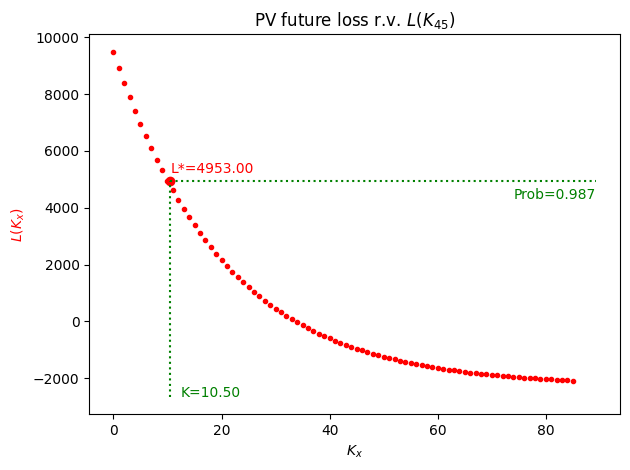

In [69]:
life = SULT().set_interest(i=0.05)
A = life.whole_life_insurance(45)
contract = Contract(benefit=10000, initial_premium=.8, renewal_premium=.1)
def fun(P):   # Solve for premium, given Loss(t=0) = 4953
    return life.L_from_t(t=10.5, contract=contract.set_contract(premium=P))
contract.set_contract(premium=life.solve(fun, target=4953, grid=100))
L = life.gross_policy_value(45, contract=contract)
life.L_plot(x=45, T=10.5, contract=contract)
isclose(-400, L, question="Q6.13")

SOA Question 6.14  (D) 1150


In [70]:
life = SULT().set_interest(i=0.05)
a = life.temporary_annuity(40, t=10) + 0.5*life.deferred_annuity(40, u=10, t=10)
A = life.whole_life_insurance(40)
P = life.gross_premium(a=a, A=A, benefit=100000)
isclose(1150, P, question="Q6.14")

----- Q6.14 1150: 1148.5800555155263 [OK] -----


True

SOA Question 6.15:  (B) 1.002


In [71]:
life = Recursion().set_interest(i=0.05).set_a(3.4611, x=0)
A = life.insurance_twin(3.4611)
udd = UDD(m=4, life=life)
a1 = udd.whole_life_annuity(x=x)
woolhouse = Woolhouse(m=4, life=life)
a2 = woolhouse.whole_life_annuity(x=x)
P = life.gross_premium(a=a1, A=A)/life.gross_premium(a=a2, A=A)
isclose(1.002, P, question="Q6.15")

----- Q6.15 1.002: 1.0022973504113772 [OK] -----


True

SOA Question 6.16: (A) 2408.6


In [72]:
life = Premiums().set_interest(d=0.05)
A = life.insurance_equivalence(premium=2143, b=100000)
a = life.annuity_equivalence(premium=2143, b=100000)
p = life.gross_premium(A=A, a=a, benefit=100000, settlement_policy=0,
                       initial_policy=250, initial_premium=0.04 + 0.35,
                       renewal_policy=50, renewal_premium=0.04 + 0.02) 
isclose(2410, p, question="Q6.16")

----- Q6.16 2410: 2408.575206281868 [OK] -----


True

SOA Question 6.17:  (A) -30000


In [73]:
x = 0
life = ConstantForce(mu=0.1).set_interest(i=0.08)
A = life.endowment_insurance(x, t=2, b=100000, endowment=30000)
a = life.temporary_annuity(x, t=2)
P = life.gross_premium(a=a, A=A)
life1 = Recursion().set_interest(i=0.08)\
                   .set_q(life.q_x(x, t=1) * 1.5, x=x, t=1)\
                   .set_q(life.q_x(x+1, t=1) * 1.5, x=x+1, t=1)
contract = Contract(premium=P*2, benefit=100000, endowment=30000)
L = life1.gross_policy_value(x, t=0, n=2, contract=contract)
isclose(-30000, L, question="Q6.17")

 *Term Insurance A_0(t=2) <--
   A_0(t=2) = v * [ q_0 * b + p_0 * A_1(t=1) ]             ~backward recursion
    p_0 = 1 - q_0                                     ~complement of mortality
    A_1(t=1) = A_1(t=1,endow=1) - E_1(t=1)         ~endowment insurance - pure
     E_1(t=1) = p_1 * v(t=1)                                   ~pure endowment
    p_1 = 1 - q_1                                     ~complement of mortality
 *Temporary Annuity a_0(t=2) <--
   a_0(t=2) = 1 + E_0(t=1) * a_1(t=1)                      ~backward recursion
    E_0(t=1) = p_0 * v(t=1)                                    ~pure endowment
     p_0 = 1 - q_0                                    ~complement of mortality
    a_1(t=1) = 1                                    ~one-year discrete annuity
 *Pure Endowment E_0(t=2) <--
   E_0(t=2) = p_0(t=2) * v(t=2)                                ~pure endowment
    p_0(t=2) = p_1 * p_0                                  ~survival chain rule
      p_0 = 1 - q_0                   

True

SOA Question 6.18:  (D) 166400


In [74]:
life = SULT().set_interest(i=0.05)
def fun(P):
    A = (life.term_insurance(40, t=20, b=P)
         + life.deferred_annuity(40, u=20, b=30000))
    return life.gross_premium(a=1, A=A) - P
P = life.solve(fun, target=0, grid=[162000, 168800])
isclose(166400, P, question="Q6.18")

----- Q6.18 166400: 166362.83871487685 [OK] -----


True

SOA Question 6.19:  (B) 0.033


In [75]:
life = SULT()
contract = Contract(initial_policy=.2, renewal_policy=.01)
a = life.whole_life_annuity(50)
A = life.whole_life_insurance(50)
contract.premium = life.gross_premium(A=A, a=a, **contract.premium_terms)
L = life.gross_policy_variance(50, contract=contract)
isclose(0.033, L, question="Q6.19")

----- Q6.19 0.033: 0.03283273381910885 [OK] -----


True

SOA Question 6.20:  (B) 459


In [76]:
life = LifeTable().set_interest(i=.04).set_table(p={75: .9, 76: .88, 77: .85})
a = life.temporary_annuity(75, t=3)
IA = life.increasing_insurance(75, t=2)
A = life.deferred_insurance(75, u=2, t=1)
def fun(P): return life.gross_premium(a=a, A=P*IA + A*10000) - P
P = life.solve(fun, target=0, grid=[449, 489])
isclose(459, P, question="Q6.20")

----- Q6.20 459: 458.83181728297353 [OK] -----


True

SOA Question 6.21:  (C) 100


In [77]:
life = Recursion(verbose=False).set_interest(d=0.04)
life.set_A(0.7, x=75, t=15, endowment=1)
life.set_E(0.11, x=75, t=15)
def fun(P):
    return (P * life.temporary_annuity(75, t=15) -
            life.endowment_insurance(75, t=15, b=1000, endowment=15*float(P)))
P = life.solve(fun, target=0, grid=(80, 120))
isclose(100, P, question="Q6.21")

----- Q6.21 100: 100.85470085470084 [OK] -----


True

SOA Question 6.22:  (C) 102


In [78]:
life=SULT(udd=True)
a = UDD(m=12, life=life).temporary_annuity(45, t=20)
A = UDD(m=0, life=life).whole_life_insurance(45)
P = life.gross_premium(A=A, a=a, benefit=100000) / 12
isclose(102, P, question="Q6.22")

----- Q6.22 102: 102.40668704849178 [OK] -----


True

SOA Question 6.23:  (D) 44.7


In [79]:
x = 0
life = Recursion().set_a(15.3926, x=x)\
                  .set_a(10.1329, x=x, t=15)\
                  .set_a(14.0145, x=x, t=30)
def fun(P):
    per_policy = 30 + (30 * life.whole_life_annuity(x))
    per_premium = (0.6 + 0.1*life.temporary_annuity(x, t=15)
                    + 0.1*life.temporary_annuity(x, t=30))
    a = life.temporary_annuity(x, t=30)
    return (P * a) - (per_policy + per_premium * P)
P = life.solve(fun, target=0, grid=[30.3, 49.5])
isclose(44.7, P, question="Q6.23")


----- Q6.23 44.7: 44.70806635781144 [OK] -----


True

SOA Question 6.24:  (E) 0.30


In [80]:
life = PolicyValues().set_interest(delta=0.07)
x, A1 = 0, 0.30   # Policy for first insurance
P = life.premium_equivalence(A=A1, discrete=False)  # Need its premium
contract = Contract(premium=P, discrete=False)
def fun(A2):  # Solve for A2, given Var(Loss)
    return life.gross_variance_loss(A1=A1, A2=A2, contract=contract)
A2 = life.solve(fun, target=0.18, grid=0.18)

contract = Contract(premium=0.06, discrete=False) # Solve second insurance
var = life.gross_variance_loss(A1=A1, A2=A2, contract=contract)
isclose(0.304, var, question="Q6.24")

----- Q6.24 0.304: 0.30419999999999975 [OK] -----


True

SOA Question 6.25:  (C) 12330


In [81]:
life = SULT()
woolhouse = Woolhouse(m=12, life=life)
benefits = woolhouse.deferred_annuity(55, u=10, b=1000 * 12)
expenses = life.whole_life_annuity(55, b=300)
payments = life.temporary_annuity(55, t=10)
def fun(P):
    return life.gross_future_loss(A=benefits + expenses, a=payments,
                                  contract=Contract(premium=P))
P = life.solve(fun, target=-800, grid=[12110, 12550])
isclose(12330, P, question="Q6.25")

----- Q6.25 12330: 12325.781125438532 [OK] -----


True

SOA Question 6.26  (D) 180


In [82]:
life = SULT().set_interest(i=0.05)
def fun(P): 
    return P - life.net_premium(90, b=1000, initial_cost=P)
P = life.solve(fun, target=0, grid=[150, 190])
isclose(180, P, question="Q6.26")

----- Q6.26 180: 180.03164891315885 [OK] -----


True

SOA Question 6.27:  (D) 10310


In [83]:
life = ConstantForce(mu=0.03).set_interest(delta=0.06)
x = 0
payments = (3 * life.temporary_annuity(x, t=20, discrete=False) 
            + life.deferred_annuity(x, u=20, discrete=False))
benefits = (1000000 * life.term_insurance(x, t=20, discrete=False)
            + 500000 * life.deferred_insurance(x, u=20, discrete=False))
P = benefits / payments
isclose(10310, P, question="Q6.27")

----- Q6.27 10310: 10309.617799001708 [OK] -----


True

SOA Question 6.28  (B) 36


In [84]:
life = SULT().set_interest(i=0.05)
a = life.temporary_annuity(40, t=5)
A = life.whole_life_insurance(40)
P = life.gross_premium(a=a, A=A, benefit=1000, 
                       initial_policy=10, renewal_premium=.05,
                       renewal_policy=5, initial_premium=.2)
isclose(36, P, question="Q6.28")

----- Q6.28 36: 35.72634219391481 [OK] -----


True

SOA Question 6.29  (B) 20.5


In [85]:
life = Premiums().set_interest(i=0.035)
def fun(a):
    return life.gross_premium(A=life.insurance_twin(a=a), a=a, 
                              initial_policy=200, initial_premium=.5,
                              renewal_policy=50, renewal_premium=.1,
                              benefit=100000)
a = life.solve(fun, target=1770, grid=[20, 22])
isclose(20.5, a, question="Q6.29")

----- Q6.29 20.5: 20.480268314431726 [OK] -----


True

SOA Question 6.30:  (A) 900


In [86]:
life = PolicyValues().set_interest(i=0.04)
contract = Contract(premium=2.338,
                    benefit=100,
                    initial_premium=.1,
                    renewal_premium=0.05)
var = life.gross_variance_loss(A1=life.insurance_twin(16.50),
                               A2=0.17, contract=contract)
isclose(900, var, question="Q6.30")

----- Q6.30 900: 908.141412994607 [OK] -----


True

SOA Question 6.31:  (D) 1330


In [87]:
life = ConstantForce(mu=0.01).set_interest(delta=0.05)
A = (life.term_insurance(35, t=35, discrete=False) 
     + life.E_x(35, t=35)*0.51791)     # A_35
P = life.premium_equivalence(A=A, b=100000, discrete=False)
isclose(1330, P, question="Q6.31")

----- Q6.31 1330: 1326.5406293909457 [OK] -----


True

SOA Question 6.32:  (C) 550


In [88]:
x = 0
life = Recursion().set_interest(i=0.05).set_a(9.19, x=x)
benefits = UDD(m=0, life=life).whole_life_insurance(x)
payments = UDD(m=12, life=life).whole_life_annuity(x)
P = life.gross_premium(a=payments, A=benefits, benefit=100000)/12
isclose(550, P, question="Q6.32")

 *Whole Life Insurance A_0(t=WL) <--
   A_x = 1 - d * a_x                                             ~annuity twin
----- Q6.32 550: 550.4356936711871 [OK] -----


True

SOA Question 6.33:  (B) 0.13


In [89]:
life = Insurance().set_survival(mu=lambda x,t: 0.02*t).set_interest(i=0.03)
x = 0
var = life.E_x(x, t=15, moment=life._VARIANCE, endowment=10000)
p = 1- life.portfolio_cdf(mean=0, variance=var, value=50000, N=500)
isclose(0.13, p, question="Q6.33", rel_tol=0.02)

----- Q6.33 0.13: 0.12828940905648634 [OK] -----


True

SOA Question 6.34:  (A) 23300


In [90]:
life = SULT()
def fun(benefit):
    A = life.whole_life_insurance(61)
    a = life.whole_life_annuity(61)
    return life.gross_premium(A=A, a=a, benefit=benefit, 
                              initial_premium=0.15, renewal_premium=0.03)
b = life.solve(fun, target=500, grid=[23300, 23700])
isclose(23300, b, question="Q6.34")

----- Q6.34 23300: 23294.288659265632 [OK] -----


True

SOA Question 6.35:  (D) 530


In [91]:
sult = SULT()
A = sult.whole_life_insurance(35, b=100000)
a = sult.whole_life_annuity(35)
P = sult.gross_premium(a=a, A=A, initial_premium=.19, renewal_premium=.04)
isclose(530, P, question="Q6.35")

----- Q6.35 530: 534.4072234303344 [OK] -----


True

SOA Question 6.36:  (B) 500


In [92]:
life = ConstantForce(mu=0.04).set_interest(delta=0.08)
a = life.temporary_annuity(50, t=20, discrete=False)
A = life.term_insurance(50, t=20, discrete=False)
def fun(R):
    return life.gross_premium(a=a, A=A, initial_premium=R/4500,
                              renewal_premium=R/4500, benefit=100000)
R = life.solve(fun, target=4500, grid=[400, 800])
isclose(500, R, question="Q6.36")

----- Q6.36 500: 500.0 [OK] -----


True

SOA Question 6.37:  (D) 820


In [93]:
sult = SULT()
benefits = sult.whole_life_insurance(35, b=50000 + 100)
expenses = sult.immediate_annuity(35, b=100)
a = sult.temporary_annuity(35, t=10)
P = (benefits + expenses) / a
isclose(820, P, question="Q6.37")

----- Q6.37 820: 819.7190338249138 [OK] -----


True

SOA Question 6.38:  (B) 11.3


In [94]:
x, n = 0, 10
life = Recursion().set_interest(i=0.05)\
                  .set_A(0.192, x=x, t=n, endowment=1, discrete=False)\
                  .set_E(0.172, x=x, t=n)
a = life.temporary_annuity(x, t=n, discrete=False)

def fun(a):   # solve for discrete annuity, given continuous
    life = Recursion(verbose=False).set_interest(i=0.05)
    life.set_a(a, x=x, t=n).set_E(0.172, x=x, t=n)
    return UDD(m=0, life=life).temporary_annuity(x, t=n)
a = life.solve(fun, target=a, grid=a)  # discrete annuity
P = life.gross_premium(a=a, A=0.192, benefit=1000)
isclose(11.3, P, question="Q6.38")

 *Temporary Annuity a_0(t=10) <--
   a_0(t=10) = [ 1 - A_0(t=10) ] / d(t=10)                       ~annuity twin
      a_0(t=1) = 1                                  ~one-year discrete annuity
      a_1(t=1) = 1                                  ~one-year discrete annuity
----- Q6.38 11.3: 11.308644185253657 [OK] -----


True

SOA Question 6.39:  (A) 29


In [95]:
sult = SULT()
P40 = sult.premium_equivalence(sult.whole_life_insurance(40), b=1000)
P80 = sult.premium_equivalence(sult.whole_life_insurance(80), b=1000)
p40 = sult.p_x(40, t=10)
p80 = sult.p_x(80, t=10)
P = (P40 * p40 + P80 * p80) / (p80 + p40)
isclose(29, P, question="Q6.39")

----- Q6.39 29: 29.033866427845496 [OK] -----


True

SOA Question 6.40: (C) 116 


In [96]:
# - standard formula discounts/accumulates by too much (i should be smaller)
x = 0
life = Recursion().set_interest(i=0.06).set_a(7, x=x+1).set_q(0.05, x=x)
a = life.whole_life_annuity(x)
A = 110 * a / 1000
life = Recursion().set_interest(i=0.06).set_A(A, x=x).set_q(0.05, x=x)
A1 = life.whole_life_insurance(x+1)
P = life.gross_premium(A=A1 / 1.03, a=7) * 1000
isclose(116, P, question="Q6.40")

 *Whole Life Annuity a_0(t=WL) <--
   a_0(t=WL) = 1 + E_0(t=1) * a_1(t=WL)                    ~backward recursion
    E_0(t=1) = p_0 * v(t=1)                                    ~pure endowment
     p_0 = 1 - q_0                                    ~complement of mortality
 *Whole Life Insurance A_1(t=WL) <--
     A_1(t=WL) = [ A_0(t=WL) /v - q_1 * b ] / p_1           ~forward recursion
      p_0 = 1 - q_0                                   ~complement of mortality
----- Q6.40 116: 116.51945397474269 [OK] -----


True

SOA Question 6.41:  (B) 1417


In [97]:
x = 0
life = LifeTable().set_interest(i=0.05).set_table(q={x:.01, x+1:.02})
a = 1 + life.E_x(x, t=1) * 1.01
A = life.deferred_insurance(x, u=0, t=1) + 1.01*life.deferred_insurance(x, u=1, t=1)
P = 100000 * A / a
isclose(1417, P, question="Q6.41")

----- Q6.41 1417: 1416.9332301924137 [OK] -----


True

SOA Question 6.42:  (D) 0.113


In [98]:
x = 0
life = ConstantForce(mu=0.06).set_interest(delta=0.06)
contract = Contract(discrete=True, premium=315.8, 
                    T=3, endowment=1000, benefit=1000)
L = [life.L_from_t(t, contract=contract) for t in range(3)]    # L(t)
Q = [life.q_x(x, u=u, t=1) for u in range(3)]              # prob(die in year t)
Q[-1] = 1 - sum(Q[:-1])   # follows SOA Solution: incorrectly treats endowment!
p = sum([q for (q, l) in zip (Q, L) if l > 0])
isclose(0.113, p, question="Q6.42")

----- Q6.42 0.113: 0.11307956328284252 [OK] -----


True

SOA Question 6.43:  (C) 170
- although 10-year term, premiums only paid first first years: separately calculate the EPV of per-policy maintenance expenses in years 6-10 and treat as additional initial expense

In [99]:
sult = SULT()
a = sult.temporary_annuity(30, t=5)
A = sult.term_insurance(30, t=10)
other_expenses = 4 * sult.deferred_annuity(30, u=5, t=5)
P = sult.gross_premium(a=a, A=A, benefit=200000, initial_premium=0.35,
                       initial_policy=8 + other_expenses, renewal_policy=4,
                       renewal_premium=0.15)
isclose(170, P, question="Q6.43")

----- Q6.43 170: 171.22371939459944 [OK] -----


True

SOA Question 6.44:  (D) 2.18


In [100]:
life = Recursion().set_interest(i=0.05)\
                  .set_IA(0.15, x=50, t=10)\
                  .set_a(17, x=50)\
                  .set_a(15, x=60)\
                  .set_E(0.6, x=50, t=10)
A = life.deferred_insurance(50, u=10)
IA = life.increasing_insurance(50, t=10)
a = life.temporary_annuity(50, t=10)
P = life.gross_premium(a=a, A=A, IA=IA, benefit=100)
isclose(2.2, P, question="Q6.44")

 *Whole Life Insurance A_60(t=WL) <--
   A_x = 1 - d * a_x                                             ~annuity twin
 *Whole Life Insurance A_60(t=WL) <--
   A_x = 1 - d * a_x                                             ~annuity twin
 *Whole Life Insurance A_60(t=WL) <--
   A_x = 1 - d * a_x                                             ~annuity twin
----- Q6.44 2.2: 2.183803457688809 [OK] -----


True

SOA Question 6.45:  (E) 690


----- Q6.45 690: 689.2659416264196 [OK] -----


True

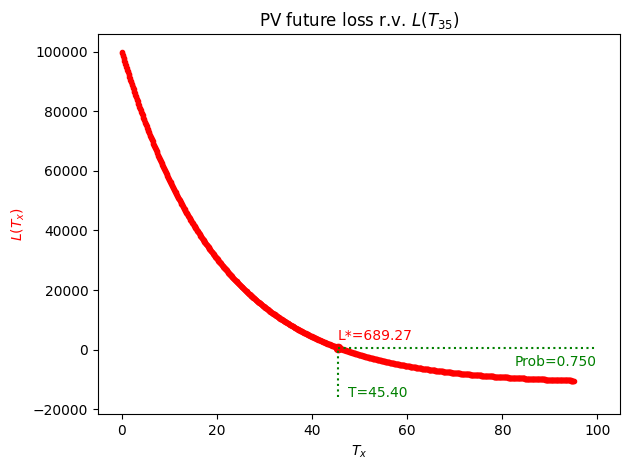

In [101]:
life = SULT(udd=True)
contract = Contract(benefit=100000, premium=560, discrete=False)
L = life.L_from_prob(x=35, prob=0.75, contract=contract)
life.L_plot(x=35, contract=contract, 
            T=life.L_to_t(L=L, contract=contract))
isclose(690, L, question="Q6.45")

SOA Question 6.46:  (E) 208


In [102]:
life = Recursion().set_interest(i=0.05)\
                  .set_IA(0.51213, x=55, t=10)\
                  .set_a(12.2758, x=55)\
                  .set_a(7.4575, x=55, t=10)
A = life.deferred_annuity(55, u=10)
IA = life.increasing_insurance(55, t=10)
a = life.temporary_annuity(55, t=10)
P = life.gross_premium(a=a, A=A, IA=IA, benefit=300)
isclose(208, P, question="Q6.46")

 *Deferred Annuity a_55(t=WL,u=10) <--
      a_55(t=1) = 1                                 ~one-year discrete annuity
      a_56(t=1) = 1                                 ~one-year discrete annuity
----- Q6.46 208: 208.12282139036515 [OK] -----


True

SOA Question 6.47:  (D) 66400


In [103]:
sult = SULT()
a = sult.temporary_annuity(70, t=10)
A = sult.deferred_annuity(70, u=10)
P = sult.gross_premium(a=a, A=A, benefit=100000, initial_premium=0.75,
                        renewal_premium=0.05)
isclose(66400, P, question="Q6.47")

----- Q6.47 66400: 66384.13293704337 [OK] -----


True

SOA Question 6.48:  (A) 3195 -- example of deep insurance recursion


In [104]:
x = 0
life = Recursion().set_interest(i=0.06)\
                  .set_p(.95, x=x, t=5)\
                  .set_q(.02, x=x+5)\
                  .set_q(.03, x=x+6)\
                  .set_q(.04, x=x+7)
a = 1 + life.E_x(x, t=5)
A = life.deferred_insurance(x, u=5, t=3)
P = life.gross_premium(A=A, a=a, benefit=100000)
isclose(3195, P, question="Q6.48")

 *Pure Endowment E_0(t=5) <--
   E_0(t=5) = p_0(t=5) * v(t=5)                                ~pure endowment
 *Pure Endowment E_0(t=5) <--
   E_0(t=5) = p_0(t=5) * v(t=5)                                ~pure endowment
 *Term Insurance A_5(t=3) <--
   A_5(t=3) = v * [ q_5 * b + p_5 * A_6(t=2) ]             ~backward recursion
    p_5 = 1 - q_5                                     ~complement of mortality
    A_6(t=2) = v * [ q_6 * b + p_6 * A_7(t=1) ]            ~backward recursion
     p_6 = 1 - q_6                                    ~complement of mortality
     A_7(t=1) = A_7(t=1,endow=1) - E_7(t=1)        ~endowment insurance - pure
      E_7(t=1) = p_7 * v(t=1)                                  ~pure endowment
     p_7 = 1 - q_7                                    ~complement of mortality
 *Term Insurance A_5(t=3) <--
   A_5(t=3) = v * [ q_5 * b + p_5 * A_6(t=2) ]             ~backward recursion
    p_5 = 1 - q_5                                     ~complement of mortality
    A_6(t=2

True

SOA Question 6.49:  (C) 86


In [105]:
sult = SULT(udd=True)
a = UDD(m=12, life=sult).temporary_annuity(40, t=20)
A = sult.whole_life_insurance(40, discrete=False)
P = sult.gross_premium(a=a, A=A, benefit=100000, initial_policy=200,
                       renewal_premium=0.04, initial_premium=0.04) / 12
isclose(86, P, question="Q6.49")

----- Q6.49 86: 85.99177833261696 [OK] -----


True

SOA Question 6.50:  (A) -47000


In [106]:
life = SULT()
P = life.premium_equivalence(a=life.whole_life_annuity(35), b=1000) 
a = life.deferred_annuity(35, u=1, t=1)
A = life.term_insurance(35, t=1, b=1000)
cash = (A - a * P) * 10000 / life.interest.v
isclose(-47000, cash, question="Q6.50")

----- Q6.50 -47000: -46948.2187697819 [OK] -----


True

SOA Question 6.51:  (D) 34700


In [107]:
life = Recursion().set_DA(0.4891, x=62, t=10)\
                   .set_A(0.0910, x=62, t=10)\
                   .set_a(12.2758, x=62)\
                   .set_a(7.4574, x=62, t=10)
IA = life.increasing_insurance(62, t=10)
A = life.deferred_annuity(62, u=10)
a = life.temporary_annuity(62, t=10)
P = life.gross_premium(a=a, A=A, IA=IA, benefit=50000)
isclose(34700, P, question="Q6.51")

 *Increasing Insurance IA_62(t=10) <--
   IA_62(t=10) = 11 A_62(t=10) - DA_62(t=10)       ~varying insurance identity
 *Deferred Annuity a_62(t=WL,u=10) <--
      a_62(t=1) = 1                                 ~one-year discrete annuity
      a_63(t=1) = 1                                 ~one-year discrete annuity
----- Q6.51 34700: 34687.207544453246 [OK] -----


True

SOA Question 6.52:  (D) 50.80

- set face value benefits to 0


In [108]:
sult = SULT()
a = sult.temporary_annuity(45, t=10)
other_cost = 10 * sult.deferred_annuity(45, u=10)
P = sult.gross_premium(a=a, A=0, benefit=0,    # set face value H = 0
                       initial_premium=1.05, renewal_premium=0.05,
                       initial_policy=100 + other_cost, renewal_policy=20)
isclose(50.8, P, question="Q6.52")

----- Q6.52 50.8: 50.80135534704229 [OK] -----


True

SOA Question 6.53:  (D) 720


In [109]:
x = 0
life = LifeTable().set_interest(i=0.08).set_table(q={x:.1, x+1:.1, x+2:.1})
A = life.term_insurance(x, t=3)
P = life.gross_premium(a=1, A=A, benefit=2000, initial_premium=0.35)
isclose(720, P, question="Q6.53")

----- Q6.53 720: 720.1646090534978 [OK] -----


True

SOA Question 6.54:  (A) 25440


In [110]:
life = SULT()
std = math.sqrt(life.net_policy_variance(45, b=200000))
isclose(25440, std, question="Q6.54")

----- Q6.54 25440: 25441.694847703857 [OK] -----


True

## 7 Policy Values

SOA Question 7.1:  (C) 11150


In [111]:
life = SULT()
x, n, t = 40, 20, 10
A = (life.whole_life_insurance(x+t, b=50000)
     + life.deferred_insurance(x+t, u=n-t, b=50000))
a = life.temporary_annuity(x+t, t=n-t, b=875)
L = life.gross_future_loss(A=A, a=a)
isclose(11150, L, question="Q7.1")

----- Q7.1 11150: 11152.108749338717 [OK] -----


True

SOA Question 7.2:  (C) 1152


In [112]:
x = 0
life = Recursion(verbose=False).set_interest(i=.1)\
                               .set_q(0.15, x=x)\
                               .set_q(0.165, x=x+1)\
                               .set_reserves(T=2, endowment=2000)

def fun(P):  # solve P s.t. V is equal backwards and forwards
    policy = dict(t=1, premium=P, benefit=lambda t: 2000, reserve_benefit=True)
    return life.t_V_backward(x, **policy) - life.t_V_forward(x, **policy)
P = life.solve(fun, target=0, grid=[1070, 1230])
isclose(1152, P, question="Q7.2")

----- Q7.2 1152: 1151.5151515151515 [OK] -----


True

SOA Question 7.3:  (E) 730


In [113]:
x = 0  # x=0 is (90) and interpret every 3 months as t=1 year
life = LifeTable().set_interest(i=0.08/4)\
                  .set_table(l={0:1000, 1:898, 2:800, 3:706})\
                  .set_reserves(T=8, V={3: 753.72})
V = life.t_V_backward(x=0, t=2, premium=60*0.9, benefit=lambda t: 1000)
V = life.set_reserves(V={2: V})\
        .t_V_backward(x=0, t=1, premium=0, benefit=lambda t: 1000)
isclose(730, V, question="Q7.3")

----- Q7.3 730: 729.998398765594 [OK] -----


True

SOA Question 7.4:  (B) -74 -- split benefits into two policies


In [114]:
life = SULT()
P = life.gross_premium(a=life.whole_life_annuity(40),
                       A=life.whole_life_insurance(40),
                       initial_policy=100, renewal_policy=10,
                       benefit=1000)
P += life.gross_premium(a=life.whole_life_annuity(40),
                        A=life.deferred_insurance(40, u=11),
                        benefit=4000)   # for deferred portion
contract = Contract(benefit=1000, premium=1.02*P, 
                    renewal_policy=10, initial_policy=100)
V = life.gross_policy_value(x=40, t=1, contract=contract)
contract = Contract(benefit=4000, premium=0)  
A = life.deferred_insurance(41, u=10)
V += life.gross_future_loss(A=A, a=0, contract=contract)   # for deferred portion
isclose(-74, V, question="Q7.4")

----- Q7.4 -74: -73.942155695248 [OK] -----


True

SOA Question 7.5:  (E) 1900


In [115]:
x = 0
life = Recursion(udd=True).set_interest(i=0.03)\
                          .set_q(0.04561, x=x+4)\
                          .set_reserves(T=3, V={4: 1405.08})
V = life.r_V_forward(x, s=4, r=0.5, benefit=10000, premium=647.46)
isclose(1900, V, question="Q7.5")

----- Q7.5 1900: 1901.766021537228 [OK] -----


True

Answer 7.6:  (E) -25.4


In [116]:
life = SULT()
P = life.net_premium(45, b=2000)
contract = Contract(benefit=2000, initial_premium=.25, renewal_premium=.05,
                    initial_policy=2*1.5 + 30, renewal_policy=2*.5 + 10)
G = life.gross_premium(a=life.whole_life_annuity(45), **contract.premium_terms)
gross = life.gross_policy_value(45, t=10, contract=contract.set_contract(premium=G))
net = life.net_policy_value(45, t=10, b=2000)
V = gross - net
isclose(-25.4, V, question="Q7.6")    

----- Q7.6 -25.4: -25.44920289521204 [OK] -----


True

SOA Question 7.7:  (D) 1110


In [117]:
x = 0
life = Recursion().set_interest(i=0.05).set_A(0.4, x=x+10)
a = Woolhouse(m=12, life=life).whole_life_annuity(x+10)
contract = Contract(premium=0, benefit=10000, renewal_policy=100)
V = life.gross_future_loss(A=0.4, contract=contract.renewals())
contract = Contract(premium=30*12, renewal_premium=0.05)
V += life.gross_future_loss(a=a, contract=contract.renewals())
isclose(1110, V, question="Q7.7")

 *Whole Life Annuity a_10(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
      a_10(t=1) = 1                                 ~one-year discrete annuity
      a_11(t=1) = 1                                 ~one-year discrete annuity
----- Q7.7 1110: 1107.9718253968258 [OK] -----


True

SOA Question 7.8:  (C) 29.85


In [118]:
sult = SULT()
x = 70
q = {x: [sult.q_x(x+k)*(.7 + .1*k) for k in range(3)] + [sult.q_x(x+3)]}
life = Recursion().set_interest(i=.05)\
                  .set_q(sult.q_x(70)*.7, x=x)\
                  .set_reserves(T=3)
V = life.t_V(x=70, t=1, premium=35.168, benefit=lambda t: 1000)
isclose(29.85, V, question="Q7.8")

 *Survival p_70 <--
   p_70 = 1 - q_70                                    ~complement of mortality
----- Q7.8 29.85: 29.85469179271202 [OK] -----


True

SOA Question 7.9:  (A) 38100


In [119]:
sult = SULT(udd=True)
x, n, t = 45, 20, 10
a = UDD(m=12, life=sult).temporary_annuity(x+10, t=n-10)
A = UDD(m=0, life=sult).endowment_insurance(x+10, t=n-10)
contract = Contract(premium=253*12, endowment=100000, benefit=100000)
V = sult.gross_future_loss(A=A, a=a, contract=contract)
isclose(38100, V, question="Q7.9")

----- Q7.9 38100: 38099.62176709246 [OK] -----


True

SOA Question 7.10: (C) -970


In [120]:
life = SULT()
G = 977.6
P = life.net_premium(45, b=100000)
contract = Contract(benefit=0, premium=G-P, renewal_policy=.02*G + 50)
V = life.gross_policy_value(45, t=5, contract=contract)
isclose(-970, V, question="Q7.10")

----- Q7.10 -970: -971.8909301877826 [OK] -----


True

SOA Question 7.11:  (B) 1460


In [121]:
life = Recursion().set_interest(i=0.05).set_a(13.4205, x=55)
contract = Contract(benefit=10000)
def fun(P):
    return life.L_from_t(t=10, contract=contract.set_contract(premium=P))
P = life.solve(fun, target=4450, grid=400)
V = life.gross_policy_value(45, t=10, contract=contract.set_contract(premium=P))
isclose(1460, V, question="Q7.11")

 *Whole Life Insurance A_55(t=WL) <--
   A_x = 1 - d * a_x                                             ~annuity twin
----- Q7.11 1460: 1459.9818035330218 [OK] -----


True

SOA Question 7.12:  (E) 4.09


In [122]:
benefit = lambda k: 26 - k
x = 44
life = Recursion().set_interest(i=0.04)\
                  .set_q(0.15, x=55)\
                  .set_reserves(T=25, endowment=1, V={11: 5.})
def fun(P):  # solve for net premium, from final year recursion
    return life.t_V(x=x, t=24, premium=P, benefit=benefit)
P = life.solve(fun, target=0.6, grid=0.5)    # solved net premium
V = life.t_V(x, t=12, premium=P, benefit=benefit)  # recursion formula
isclose(4.09, V, question="Q7.12")

 *Survival p_55 <--
   p_55 = 1 - q_55                                    ~complement of mortality
----- Q7.12 4.09: 4.089411764705883 [OK] -----


True

Answer 7.13: (A) 180


In [123]:
life = SULT()
V = life.FPT_policy_value(40, t=10, n=30, endowment=1000, b=1000)
isclose(180, V, question="Q7.13")

----- Q7.13 180: 180.1071785904076 [OK] -----


True

SOA Question 7.14:  (A) 2200


In [124]:
x = 45
life = Recursion(verbose=False).set_interest(i=0.05)\
                               .set_q(0.009, x=50)\
                               .set_reserves(T=10, V={5: 5500})
def fun(P):  # solve for net premium,
    return life.t_V(x=x, t=6, premium=P*0.96 - 50, benefit=lambda t: 100000+200)
P = life.solve(fun, target=7100, grid=[2200, 2400])
isclose(2200, P, question="Q7.14")

----- Q7.14 2200: 2197.8174603174602 [OK] -----


True

SOA Question 7.15:  (E) 50.91


In [125]:
x = 0
V = Recursion(udd=True).set_interest(i=0.05)\
                       .set_q(0.1, x=x+15)\
                       .set_reserves(T=3, V={16: 49.78})\
                       .r_V_backward(x, s=15, r=0.6, benefit=100)
isclose(50.91, V, question="Q7.15")

----- Q7.15 50.91: 50.91362826922369 [OK] -----


True

SOA Question 7.16:  (D) 380


In [126]:
life = SelectLife().set_interest(v=.95)\
                   .set_table(A={86: [683/1000]},
                              q={80+k: [.01*(k+1)] for k in range(6)})
x, t, n = 80, 3, 5
A = life.whole_life_insurance(x+t)
a = life.temporary_annuity(x+t, t=n-t)
V = life.gross_future_loss(A=A, a=a, contract=Contract(benefit=1000, premium=130))
isclose(380, V, question="Q7.16")

----- Q7.16 380: 381.6876905200001 [OK] -----


True

SOA Question 7.17:  (D) 1.018


In [127]:
x = 0
life = Recursion().set_interest(v=math.sqrt(0.90703))\
                  .set_q(0.02067, x=x+10)\
                  .set_A(0.52536, x=x+11)\
                  .set_A(0.30783, x=x+11, moment=2)
A1 = life.whole_life_insurance(x+10)
A2 = life.whole_life_insurance(x+10, moment=2)
ratio = (life.insurance_variance(A2=A2, A1=A1) 
         / life.insurance_variance(A2=0.30783, A1=0.52536))
isclose(1.018, ratio, question="Q7.17")

 *Whole Life Insurance A_10(t=WL) <--
   A_10(t=WL) = v * [ q_10 * b + p_10 * A_11(t=WL) ]       ~backward recursion
    p_10 = 1 - q_10                                   ~complement of mortality
 *Whole Life Insurance A_10(t=WL,mom=2) <--
   A_10(t=WL,mom=2) = v^2 * [ q_10 * b^2 + p_10 * A_11(t=WL,mom=2) ]     ~backward recursion
    p_10 = 1 - q_10                                   ~complement of mortality
----- Q7.17 1.018: 1.0182465434445054 [OK] -----


True

SOA Question 7.18:  (A) 17.1


In [128]:
x = 10
life = Recursion(verbose=False).set_interest(i=0.04).set_q(0.009, x=x)
def fun(a):
    return life.set_a(a, x=x).net_policy_value(x, t=1)
a = life.solve(fun, target=0.012, grid=[17.1, 19.1])
isclose(17.1, a, question="Q7.18")

----- Q7.18 17.1: 17.07941929974385 [OK] -----


True

SOA Question 7.19:  (D) 720


In [129]:
life = SULT()
contract = Contract(benefit=100000,
                    initial_policy=300,
                    initial_premium=.5,
                    renewal_premium=.1)
P = life.gross_premium(A=life.whole_life_insurance(40), **contract.premium_terms)
A = life.whole_life_insurance(41)
a = life.immediate_annuity(41)   # after premium and expenses are paid
V = life.gross_future_loss(A=A,
                           a=a,
                           contract=contract.set_contract(premium=P).renewals())
isclose(720, V, question="Q7.19")

----- Q7.19 720: 722.7510208759086 [OK] -----


True

SOA Question 7.20: (E) -277.23


In [130]:
life = SULT()
S = life.FPT_policy_value(35, t=1, b=1000)  # is 0 for FPT at t=0,1
contract = Contract(benefit=1000,
                    initial_premium=.3,
                    initial_policy=300,
                    renewal_premium=.04,
                    renewal_policy=30)
G = life.gross_premium(A=life.whole_life_insurance(35), **contract.premium_terms)
R = life.gross_policy_value(35, t=1, contract=contract.set_contract(premium=G))
isclose(-277.23, R - S, question="Q7.20")

----- Q7.20 -277.23: -277.19303323929216 [OK] -----


True

SOA Question 7.21:  (D) 11866


In [131]:
life = SULT()
x, t, u = 55, 9, 10
P = life.gross_premium(IA=0.14743,
                       a=life.temporary_annuity(x, t=u),
                       A=life.deferred_annuity(x, u=u),
                       benefit=1000)
contract = Contract(initial_policy=life.term_insurance(x+t, t=1, b=10*P),
                    premium=P,
                    benefit=1000)
a = life.temporary_annuity(x+t, t=u-t)
A = life.deferred_annuity(x+t, u=u-t)
V = life.gross_future_loss(A=A, a=a, contract=contract)
isclose(11866, V, question="Q7.21")

----- Q7.21 11866: 11866.30158100453 [OK] -----


True

SOA Question 7.22:  (C) 46.24


In [132]:
life = PolicyValues().set_interest(i=0.06)
contract = Contract(benefit=8, premium=1.250)
def fun(A2): 
    return life.gross_variance_loss(A1=0, A2=A2, contract=contract)
A2 = life.solve(fun, target=20.55, grid=20.55/8**2)
contract = Contract(benefit=12, premium=1.875)
var = life.gross_variance_loss(A1=0, A2=A2, contract=contract)
isclose(46.2, var, question="Q7.22")

----- Q7.22 46.2: 46.2375 [OK] -----


True

SOA Question 7.23:  (D) 233


In [133]:
life = Recursion().set_interest(i=0.04).set_p(0.995, x=25)
A = life.term_insurance(25, t=1, b=10000)
def fun(beta):  # value of premiums in first 20 years must be equal
    return beta * 11.087 + (A - beta) 
beta = life.solve(fun, target=216 * 11.087, grid=[140, 260])
isclose(233, beta, question="Q7.23")

 *Term Insurance A_25(t=1,b=10000) <--
   A_25(t=1) = A_25(t=1,endow=10000) - E_25(t=1,endow=10000)     ~endowment insurance - pure
    E_25(t=1) = p_25 * v(t=1)                                  ~pure endowment
----- Q7.23 233: 232.64747466274176 [OK] -----


True

SOA Question 7.24:  (C) 680


In [134]:
life = SULT()
P = life.premium_equivalence(A=life.whole_life_insurance(50), b=1000000)
isclose(680, 11800 - P, question="Q7.24")

----- Q7.24 680: 680.291823645397 [OK] -----


True

SOA Question 7.25:  (B) 3947.37


In [135]:
life = SelectLife().set_interest(i=.04)\
                   .set_table(A={55: [.23, .24, .25],
                                 56: [.25, .26, .27],
                                 57: [.27, .28, .29],
                                 58: [.20, .30, .31]})
V = life.FPT_policy_value(55, t=3, b=100000)
isclose(3950, V, question="Q7.25")

----- Q7.25 3950: 3947.3684210526353 [OK] -----


True

SOA Question 7.26:  (D) 28540 
- backward = forward reserve recursion


In [136]:
x = 0
life = Recursion(verbose=False).set_interest(i=.05)\
                               .set_p(0.85, x=x)\
                               .set_p(0.85, x=x+1)\
                               .set_reserves(T=2, endowment=50000)
def benefit(k): return k * 25000
def fun(P):  # solve P s.t. V is equal backwards and forwards
    policy = dict(t=1, premium=P, benefit=benefit, reserve_benefit=True)
    return life.t_V_backward(x, **policy) - life.t_V_forward(x, **policy)
P = life.solve(fun, target=0, grid=[27650, 28730])
isclose(28540, P, question="Q7.26")

----- Q7.26 28540: 28542.392566782808 [OK] -----


True

SOA Question 7.27:  (B) 213


In [137]:
x = 0
life = Recursion(verbose=False).set_interest(i=0.03)\
                               .set_q(0.008, x=x)\
                               .set_reserves(V={0: 0})
def fun(G):  # Solve gross premium from expense reserves equation
    return life.t_V(x=x, t=1, premium=G - 187, benefit=lambda t: 0,
                    per_policy=10 + 0.25*G)
G = life.solve(fun, target=-38.70, grid=[200, 252])
isclose(213, G, question="Q7.27")

----- Q7.27 213: 212.970355987055 [OK] -----


True

SOA Question 7.28:  (D) 24.3


In [138]:
life = SULT()
PW = life.net_premium(65, b=1000)   # 20_V=0 => P+W is net premium for A_65
P = life.net_premium(45, t=20, b=1000)  # => P is net premium for A_45:20
isclose(24.3, PW - P, question="Q7.28")

----- Q7.28 24.3: 24.334725400123975 [OK] -----


True

SOA Question 7.29:  (E) 2270


In [139]:
x = 0
life = Recursion(verbose=False).set_interest(i=0.04)\
                               .set_a(14.8, x=x)\
                               .set_a(11.4, x=x+10)
def fun(B): 
    return life.net_policy_value(x, t=10, b=B)
B = life.solve(fun, target=2290, grid=2290*10)  # Solve benefit B given net 10_V
contract = Contract(initial_policy=30, renewal_policy=5, benefit=B)
G = life.gross_premium(a=life.whole_life_annuity(x), **contract.premium_terms)
V = life.gross_policy_value(x, t=10, contract=contract.set_contract(premium=G))
isclose(2270, V, question="Q7.29")

----- Q7.29 2270: 2270.743243243244 [OK] -----


True

SOA Question 7.30:  (E) 9035


In [140]:
contract = Contract(premium=0, benefit=10000)  # premiums=0 after t=10
L = SULT().gross_policy_value(35, contract=contract)
V = SULT().set_interest(i=0).gross_policy_value(35, contract=contract) # 10000
isclose(9035, V - L, question="Q7.30")

----- Q7.30 9035: 9034.654127845053 [OK] -----


True

SOA Question 7.31:  (E) 0.310


In [141]:
x = 0
life = Reserves().set_reserves(T=3)
G = 368.05
def fun(P):  # solve net premium expense reserve equation
    return life.t_V(x, t=2, premium=G-P, benefit=lambda t:0, per_policy=5+0.08*G)
P = life.solve(fun, target=-23.64, grid=[.29, .31]) / 1000
isclose(0.310, P, question="Q7.31")

----- Q7.31 0.31: 0.309966 [OK] -----


True

SOA Question 7.32:  (B) 1.4


In [142]:
life = PolicyValues().set_interest(i=0.06)
contract = Contract(benefit=1, premium=0.1)
def fun(A2): 
    return life.gross_variance_loss(A1=0, A2=A2, contract=contract)
A2 = life.solve(fun, target=0.455, grid=0.455)
contract = Contract(benefit=2, premium=0.16)
var = life.gross_variance_loss(A1=0, A2=A2, contract=contract)
isclose(1.39, var, question="Q7.32")

----- Q7.32 1.39: 1.3848168384380901 [OK] -----


True

__Final Score__

In [143]:
from datetime import datetime
print(datetime.now())
print(isclose)

2023-06-05 17:15:45.838579
Passed: 136/136

